# Notebook Description

Correlation between RMM and AWAP rainfall indices in MJO subphases.

# Packages

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
from constants import NWABounds
import constants
import calculation_functions
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import spearmanr

import matplotlib.gridspec as gridspec

In [2]:
import sys
from importlib import reload
sys.path.append('')
import load_dataset as load
import phase_calc_functions as phase_calc
import map_trend_functions
import plotting_functions as pf
import miscellaneous#apply_masks

In [3]:
import matplotlib
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)

import matplotlib.pylab as pylab

params = {'axes.labelsize' : 16,
         'legend.fontsize': 'x-large',
          'axes.titlesize': 'xx-large',
         }

pylab.rcParams.update(params)

In [4]:
image_dir = '/g/data/w40/ab2313/images/mjo_and_rainfall_trend_images/'

# Data

In [98]:
# Loading awap
awap = load.load_awap()
awap_ws = phase_calc.wet_season_year(awap)

# Loading RMM
rmm = load.load_rmm()
rmm_ws = phase_calc.wet_season_year(rmm)

awap_ws, rmm_ws = calculation_functions.match_dataset_time(awap_ws, rmm_ws)
awap_ws = miscellaneous.apply_masks(awap_ws)

New datasets are now of lenght d1 = 5578 and d2 = 5578


# Calculations

In [99]:
# Splitting AWAP into the the different phases of the Wheeler and Hendon MJO
awap_split_ws = phase_calc.split_into_1to8(awap_ws, rmm_ws)

In [100]:
rmm_count = phase_calc.count_in_rmm_phase(rmm_ws)
rmm_count_sub = phase_calc.resample_phase_to_subphase(rmm_count)
rmm_count_sub

Enhanced phase definition being used [5, 6]


<xarray.Dataset>
Dimensions:  (phase: 4, year: 46)
Coordinates:
  * year     (year) int64 1974 1975 1976 1977 1978 ... 2015 2016 2017 2018 2019
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
Data variables:
    number   (phase, year) int64 12 25 22 9 12 19 11 19 ... 43 29 18 56 15 23 46

# RMM Enahnced with Total Monsoon Rainfall

In [101]:
def create_trend_line(y_values, x_values=None): 
    
    if x_values is None: x_values = np.arange(len(y_values))
    grad, y_int = np.polyfit(x_values,y_values,1)    
    
    y_line = grad * x_values + y_int
    
    return y_line

In [102]:
def detrend_dataset(da: xr.DataArray) -> xr.DataArray:
    time_axis_name = 'time' if 'time' in list(da.coords) else 'year'
    time_axis_num = da.get_axis_num(time_axis_name)
    trend_np = np.apply_along_axis(create_trend_line, time_axis_num, da.values, da[time_axis_name].values)

    da_trend = xr.zeros_like(da) + trend_np
    da_detrend = da - da_trend
    return da_detrend

In [103]:
rmm_sub_detrend_ds = rmm_count_sub#detrend_dataset(rmm_count_sub.number).to_dataset()

In [104]:
rmm_count_sub_enhanced_detrend = rmm_sub_detrend_ds.sel(phase='enhanced')

## Grid Cell

### Calculations

In [105]:
awap_sum = calculation_functions.resample_sum(awap_ws)
awap_count = calculation_functions.resample_count(awap_ws)
awap_count

<xarray.Dataset>
Dimensions:  (year: 46, lat: 80, lon: 161)
Coordinates:
  * lat      (lat) float64 -30.0 -29.75 -29.5 -29.25 ... -10.5 -10.25 -10.0
  * lon      (lon) float64 113.5 113.8 114.0 114.2 ... 152.8 153.0 153.2 153.5
  * year     (year) int64 1974 1975 1976 1977 1978 ... 2015 2016 2017 2018 2019
Data variables:
    precip   (year, lat, lon) int64 0 0 0 0 0 0 5 6 5 8 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    Information:  Only contains the wet season [10,11,12,1,2,3],rainfall >= 1...
    History:      AGCD Regrid on the 11th of June 2021 from /g/data/rr5 by ab...

In [106]:
awap_sum_detrend_ds = awap_sum_detrend_ds#detrend_dataset(awap_sum.precip).to_dataset()
awap_count_detrend_ds = awap_count#detrend_dataset(awap_count.precip).to_dataset()

In [107]:
awap_count_rmm_cor = xr.corr(awap_count_detrend_ds.precip, rmm_sub_detrend_ds.number, dim='year')
awap_sum_rmm_cor = xr.corr(awap_sum_detrend_ds.precip, rmm_sub_detrend_ds.number, dim='year')
awap_sum_rmm_cor.name='sum'
awap_count_rmm_cor.name='count'
total_monsoon_rainfall_and_phase_correlation_ds = xr.merge([awap_sum_rmm_cor,awap_count_rmm_cor ])
total_monsoon_rainfall_and_phase_correlation_ds

<xarray.Dataset>
Dimensions:  (lat: 80, lon: 161, phase: 4)
Coordinates:
  * lat      (lat) float64 -30.0 -29.75 -29.5 -29.25 ... -10.5 -10.25 -10.0
  * lon      (lon) float64 113.5 113.8 114.0 114.2 ... 152.8 153.0 153.2 153.5
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
Data variables:
    sum      (lat, lon, phase) float64 nan nan nan nan nan ... nan nan nan nan
    count    (lat, lon, phase) float64 nan nan nan nan nan ... nan nan nan nan

### Plotting

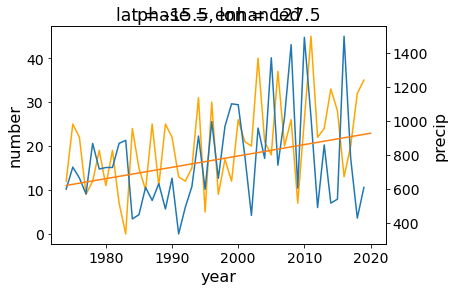

In [108]:
fig= plt.figure()
ax = fig.add_subplot(111)
rmm_sub_detrend_ds.sel(phase='enhanced').number.plot(ax=ax, color='orange', label='rmm')
ax2 = ax.twinx()
awap_sum.sel(lat=-15.6, lon=127.5, method='nearest').precip.plot(ax=ax2)
awap_sum_trend_ds.sel(lat=-15.6, lon=127.5, method='nearest').precip.plot(ax=ax2)

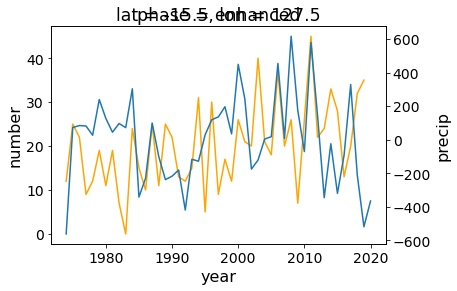

In [109]:
fig= plt.figure()
ax = fig.add_subplot(111)
rmm_sub_detrend_ds.sel(phase='enhanced').number.plot(ax=ax, color='orange', label='rmm')
ax2 = ax.twinx()
awap_sum_detrend_ds.sel(lat=-15.6, lon=127.5, method='nearest').precip.plot(ax=ax2)


In [110]:
col_titles = ['Number of Raindays', 'Rainfall']

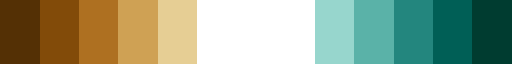

In [111]:
levels = pf.create_levels(vmax=.6, step=.1)
cmap_correlation = pf.create_discrete_cmap('BrBG', levels=levels, add_white=True)
cmap_correlation

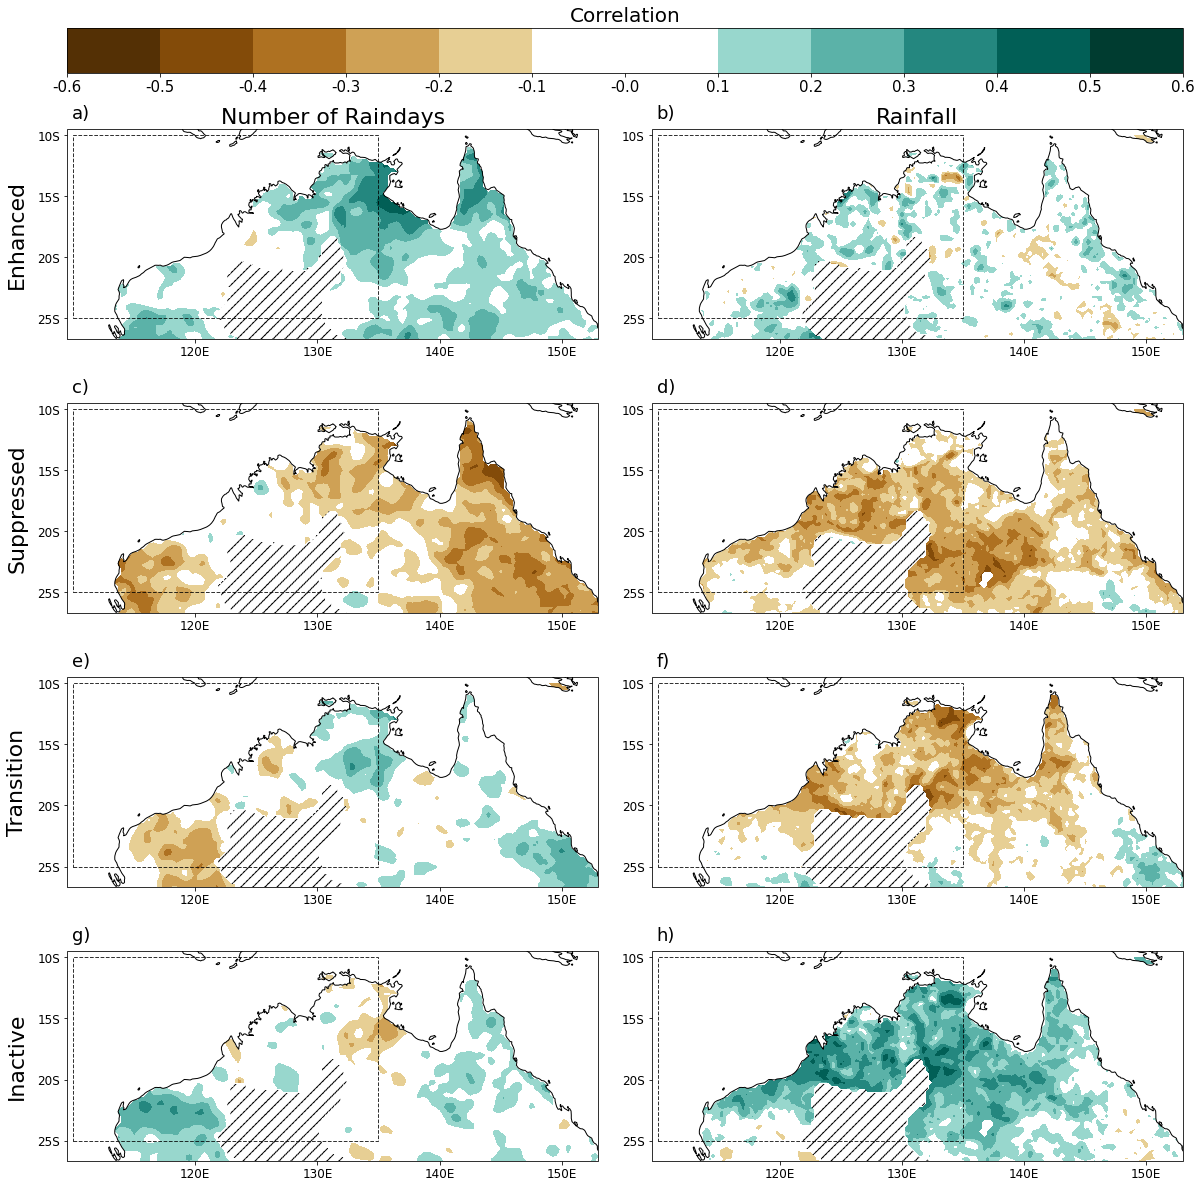

In [112]:
fig = pf.datavars_as_col_plot(total_monsoon_rainfall_and_phase_correlation_ds, 'phase', vmax = .6, step = .1,
                       colorbar_title = 'Correlation', col_titles=col_titles, 
                             round_level=1, tick_symbol=None, cmap=cmap_correlation)

# fig.savefig(
#     os.path.join(constants.IMAGE_SAVE_DIR,
#  '04_total_wet_season_rainfall_correlation_with_number_days_and_total_rainfall_in_rmm_phase.png'),
#            dpi=500, bbox_inches='tight')

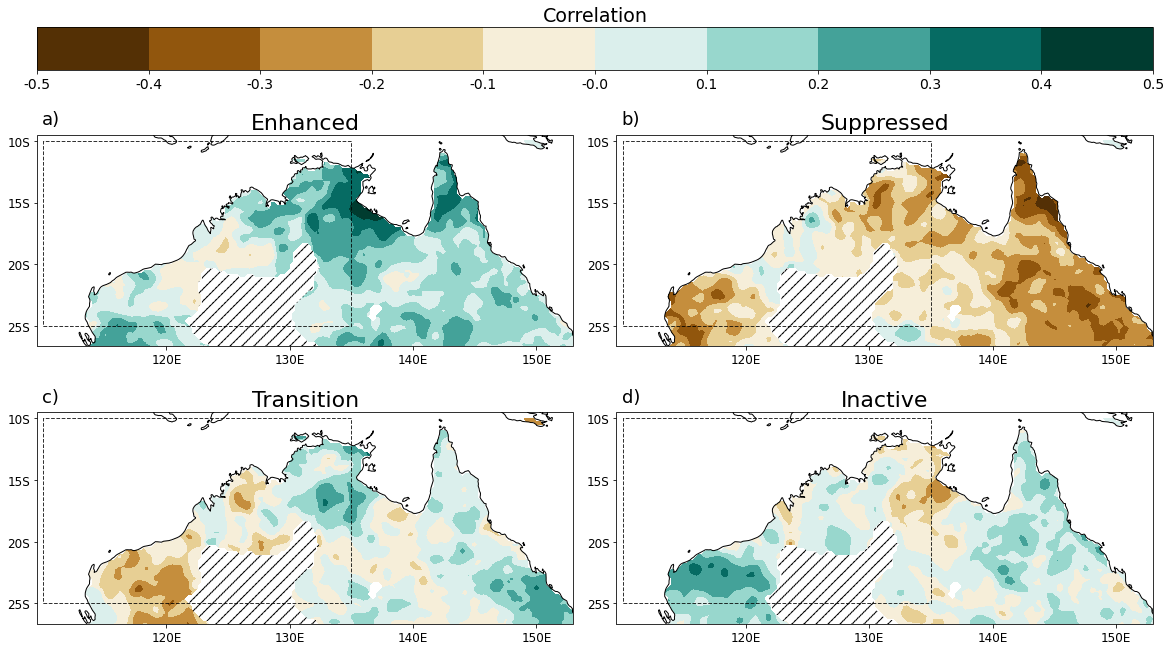

In [113]:
fig = pf.all_phase_trend_plots(awap_sum_rmm_cor,
               vmax = 0.5, step = 0.1, cmap = 'BrBG', tick_symbol=None, round_level=1,
                               colorbar_title = 'Correlation'
               )
# fig.savefig(
#     os.path.join(constants.IMAGE_SAVE_DIR, 
#                  '04_total_wet_season_rainfall_correlation_with_number_days_in_rmm_phase.png'),
#            dpi=500, bbox_inches='tight')

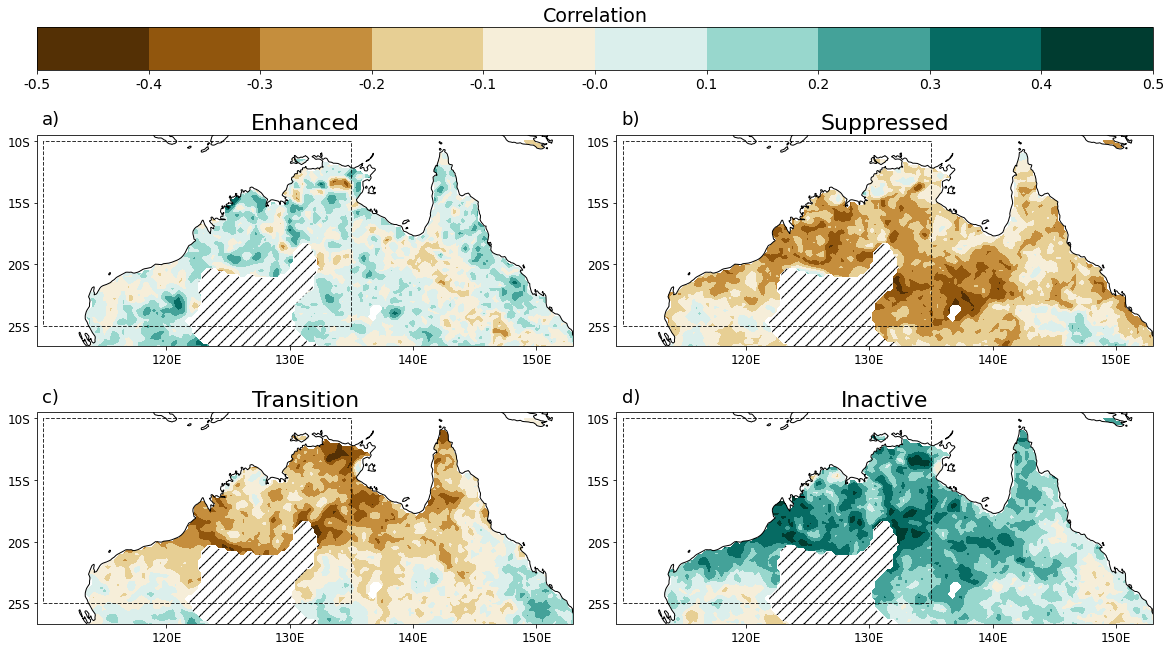

In [114]:
reload(map_trend_functions)
fig = pf.all_phase_trend_plots(awap_count_rmm_cor,
               vmax = 0.5, step = 0.1, cmap = 'BrBG', tick_symbol=None, round_level=1,
                               colorbar_title = 'Correlation'
               )
# fig.savefig(
#     os.path.join(constants.IMAGE_SAVE_DIR, 
#                  '04_total_wet_season_number_rain_days_correlation_with_number_days_in_rmm_phase.png'),
#            dpi=500, bbox_inches='tight')

## Global Average

In [115]:
awap_sum_agg = awap_count.sel(
    lat=slice(*NWABounds.lat), lon=slice(*NWABounds.lon)).mean(dim=['lat', 'lon'])
awap_sum_agg

<xarray.Dataset>
Dimensions:  (year: 46)
Coordinates:
  * year     (year) int64 1974 1975 1976 1977 1978 ... 2015 2016 2017 2018 2019
Data variables:
    precip   (year) float64 15.88 20.44 17.17 19.22 ... 23.37 17.66 12.13 13.58

In [116]:
awap_sum_agg_trend = create_trend_line(awap_sum_agg.precip.values, awap_sum_agg.year.values)

In [117]:
awap_sum_agg_detrend = awap_sum_agg - awap_sum_agg_trend

In [118]:
# plt.plot(rmm_count_sub.year.values, rmm_count_trend)
# rmm_count_sub.sel(phase='enhanced').number.plot()
# rmm_count_sub_enhanced_detrend.number.plot()

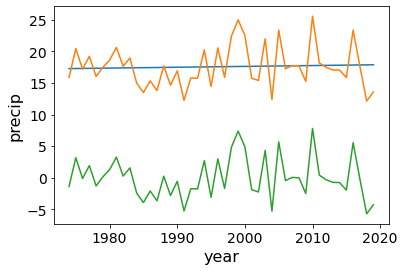

In [119]:
plt.plot(awap_sum_agg.year.values, awap_sum_agg_trend)
awap_sum_agg.precip.plot()
awap_sum_agg_detrend.precip.plot()

In [120]:
from scipy.stats import pearsonr

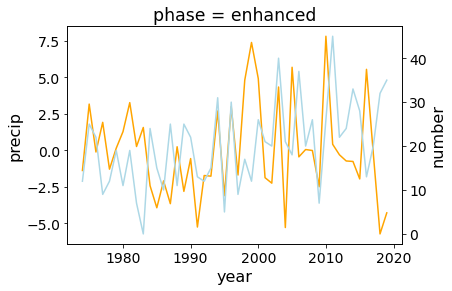

In [121]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
awap_sum_agg_detrend.precip.plot(ax=ax1, c='orange')
ax2 = ax1.twinx()
rmm_count_sub_enhanced_detrend.number.plot(ax=ax2, c='lightblue')

In [122]:
pearsonr(awap_sum_agg_detrend.precip.values, rmm_count_sub_enhanced_detrend.number.values)[0]

0.03544798950203497

In [123]:
rmm_count_sub.sel(phase='enhanced')

<xarray.Dataset>
Dimensions:  (year: 46)
Coordinates:
  * year     (year) int64 1974 1975 1976 1977 1978 ... 2015 2016 2017 2018 2019
    phase    <U8 'enhanced'
Data variables:
    number   (year) int64 12 25 22 9 12 19 11 19 7 ... 22 24 33 28 13 20 32 35

In [124]:
from scipy.stats import spearmanr

correlation_sum_agg = spearmanr(awap_sum_agg.precip.values, rmm_count_sub.sel(phase='enhanced').number.values)
correlation_sum_agg

SpearmanrResult(correlation=0.056488486475225544, pvalue=0.7092394220825662)

Text(0, 0.5, 'Mean Total Monsoon Rain Days')

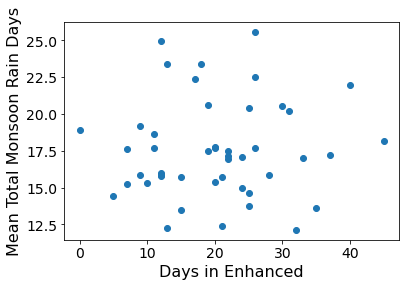

In [125]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(rmm_count_sub.sel(phase='enhanced').number.values, awap_sum_agg.precip.values)
ax.set_xlabel('Days in Enhanced')
ax.set_ylabel('Mean Total Monsoon Rain Days')

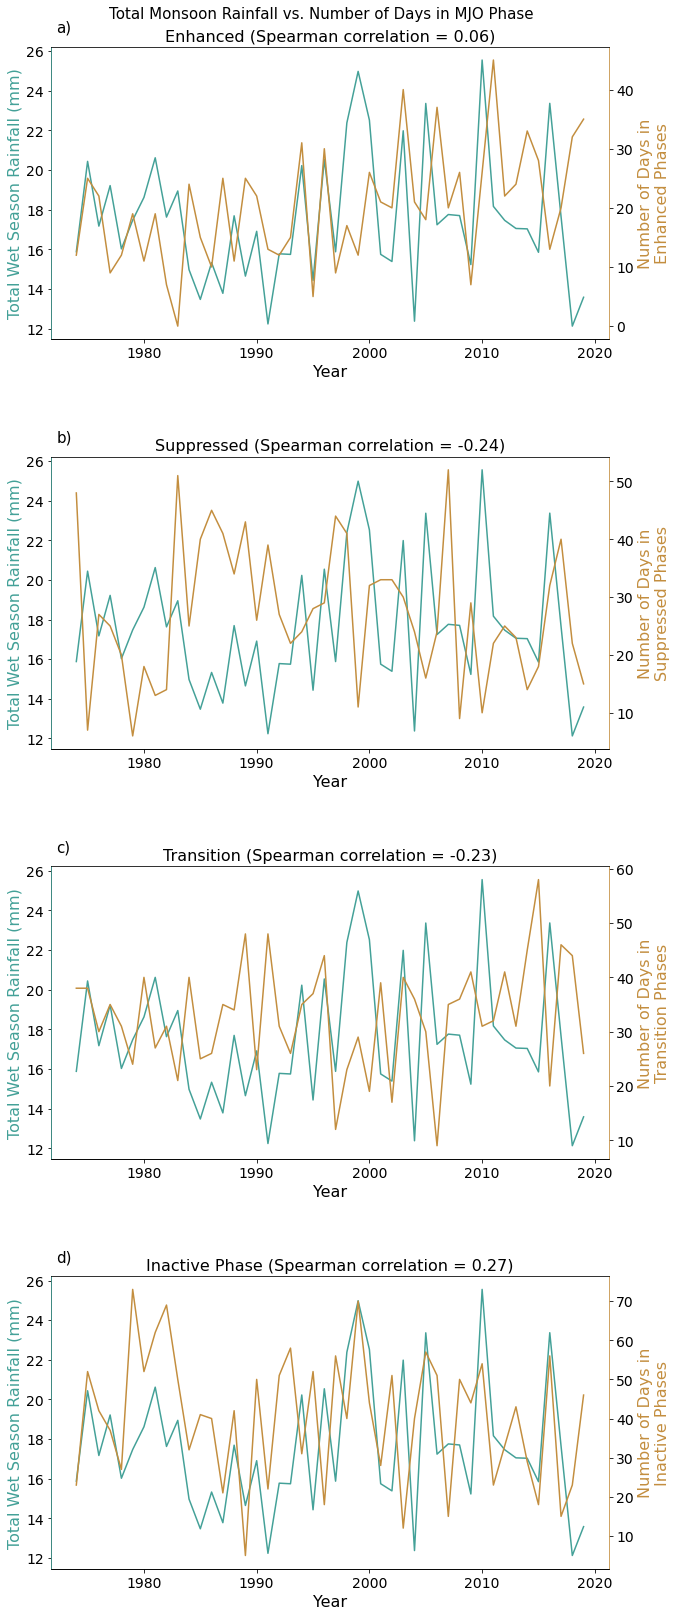

In [126]:
fig = plt.figure(figsize = (10,28/4*4)) #(18,20))
gs = gridspec.GridSpec(4,1, hspace = 0.4)


sig_stor = []

years = awap_sum_agg.year.values

for i, phase in enumerate(rmm_count_sub.phase.values):
    ax = fig.add_subplot(gs[i])
    
    ax.plot(years, awap_sum_agg.precip.values, color=constants.green, 
            label='Total Wet Season Rainfall (mm)')
    ax2 = ax.twinx()
    ax2.plot(years, rmm_count_sub.sel(phase=phase).number.values, color=constants.brown, 
             label='Days in MJO Phase')


    ax.set_ylabel('Total Wet Season Rainfall (mm)', color=constants.green)
    ax2.set_ylabel(f'Number of Days in\n{phase.capitalize()} Phases', color=constants.brown)                     
    ax.set_xlabel('Year')
    
#     leg = ax.legend(loc = 'upper left', ncol=2)
    scor = spearmanr(awap_sum_agg.precip.values, rmm_count_sub.sel(phase=phase).number.values)
    title = phase.capitalize() if phase != 'inactive' else 'Inactive Phase'
    title = title + f' (Spearman correlation = {scor[0]:.2f})'
    ax.set_title(title, size=16)

#     leg.set_title(f'Correlation - {scor[0]:.2f}')
    
    ax2.spines['left'].set_color(constants.green)
    ax2.spines['right'].set_color(constants.brown)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.annotate(chr(97+i) +')', xy = (0.01,1.05), xycoords = 'axes fraction', size = 15)


title = 'Total Monsoon Rainfall vs. Number of Days in MJO Phase'
fig.suptitle(title, y =0.9, fontsize = 15 );


# fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR, '04_enhanced_trend_and_phase_sum_rainfall.png'), 
#                          dpi = 800, bbox_inches = 'tight')

In [127]:
scor[0]

0.2721185812126504

# Phase

In [ ]:
awap_count_phase = calculation_functions.resample_count(awap_split_ws)
awap_count_sub = phase_calc.resample_phase_to_subphase(awap_count_phase)
awap_count_sub 

In [ ]:
awap_sum_phase = calculation_functions.resample_sum(awap_split_ws)
awap_sum_sub = phase_calc.resample_phase_to_subphase(awap_sum_phase)
awap_sum_sub 

In [ ]:
awap_int = awap_sum.sum(dim='year')/awap_count.sum(dim='year')
awap_int

In [ ]:
awap_sum_sub

In [ ]:
sum_corr_da = xr.corr(awap_sum_sub.precip, rmm_count_sub.number, dim='year')
count_corr_da = xr.corr(awap_count_sub.precip, rmm_count_sub.number, dim='year')
sum_corr_da

In [ ]:
np.max([sum_corr_da.max().values, sum_corr_da.max().values])

In [ ]:
reload(map_trend_functions)
map_trend_functions.trend_plots(sum_corr_da,
               vmax = 0.9, step = 0.15, cmap = 'BrBG', tick_symbol=None, round_level=1,
               title = '04_phase_rainfall_correlation_with_number_days_in_rmm_phase', colorbar_title = 'Correlation'
               , savedir = constants.IMAGE_SAVE_DIR
               )

In [ ]:
reload(map_trend_functions)
map_trend_functions.trend_plots(count_corr_da,
               vmax = 1, step = 0.2, cmap = 'BrBG', tick_symbol=None, round_level=1,
               title = '04_phase_rain_days_correlation_with_number_days_in_rmm_phase', colorbar_title = 'Correlation'
               , savedir = constants.IMAGE_SAVE_DIR
               )

## Space Aggregation

In [ ]:
awap_sum_sub

In [ ]:
awap_sum_sub_space_agg = awap_sum_sub.sel(
    lat=slice(*NWABounds.lat), lon=slice(*NWABounds.lon)).sum(dim=['lat', 'lon'])
awap_count_sub_space_agg = awap_count_sub.sel(
    lat=slice(*NWABounds.lat), lon=slice(*NWABounds.lon)).sum(dim=['lat', 'lon'])
awap_sum_sub_space_agg

In [ ]:
phase = 'enhanced'

fig = plt.figure()
ax = fig.add_subplot(111)
awap_sum_sub_space_agg.sel(phase=phase).precip.plot(ax=ax)
ax2 = ax.twinx()
rmm_count_sub.sel(phase=phase).number.plot(ax=ax2, color='orange')

In [ ]:
sum_agg_corr = xr.corr(awap_sum_sub_space_agg.precip, rmm_count_sub.number, dim='year')
sum_agg_corr

In [ ]:
count_agg_corr = xr.corr(awap_count_sub_space_agg.precip, rmm_count_sub.number, dim='year')
count_agg_corr

In [ ]:
# fig = plt.figure(figsize = (10,28/9*4))#(18,20))
# gs = gridspec.GridSpec(4,1, hspace = 0.4)


# sig_stor = []

# for i,phase in enumerate(subphase_count_ot.phase.values):
#     ax = fig.add_subplot(gs[i])
    
#     single_phase_ot = subphase_count_ot.sel(phase = phase).number
#     mjo_single_phase_line_plot(ax, single_phase_ot, linecolor=green, label='OT')
    
    
#     single_phase_wh = subphase_count_wh.sel(phase = phase).number
#     mjo_single_phase_line_plot(ax, single_phase_wh, linecolor=brown, label='WH')
    
    
#     # Defining titles
#     if phase == 'inactive':
#         ax.set_title('Inactive Phase', size=16)
#         ax.set_ylim([0, 90])
#     else:
#         ax.set_title(phase.capitalize(), size=16)
#         ax.set_ylim(0,60)
#     ax.set_ylabel('Number of Days')
#     ax.set_xlabel('Year')
#     leg = ax.legend(loc = 'upper left', ncol=2)
#     leg.set_title(f'Correlation - {pcor:.2f}')
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.annotate(chr(97+i) +')', xy = (0.01,1.05), xycoords = 'axes fraction', size = 15)


# title = 'Number of Days in each MJO Phase per Year'
# fig.suptitle(title, y =0.94, fontsize = 15 );


# fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR, 'rmm_trend_subphase_DecToMarch_OT_and_WH_col1_4rows.png'), 
#                          dpi = 800, bbox_inches = 'tight')